In [ ]:
! pip install AutoTS
!pip install ucimlrepo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.0/851.0 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from autots import AutoTS
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


##**1. Preparación de los datos**

In [ ]:
#Descarga de datasets de la colección UCI Machine Learning Repository

from ucimlrepo import fetch_ucirepo

air_quality = fetch_ucirepo(id=360)

Xair = air_quality.data.features
yair = air_quality.data.targets


In [ ]:
# Crear el DataFrame con todas las características
df_total= air_quality.data.features

#Seleccionar las columnas específicas con las que se va a trabajar
df = df_total[['Date', 'Time', 'C6H6(GT)', 'T', 'RH']]

In [ ]:
# Cambiar el nombre de la variable C6H6(GT)
df = df.rename(columns={'C6H6(GT)': 'C6H6'})

In [ ]:
# Crear columna Datetime combinada
df['Datetime'] = df['Date'] + ' ' + df['Time']

# Intentar convertir a datetime y capturar el error
# En lugar de poner format='%d/%m/%Y %H:%M:%S' poner dayfirst=False para que infiera automaticamente el formato
try:
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)
except ValueError as e:
    print(f"Error al convertir fechas: {e}")

# Mostrars las filas que no se convirtieron correctamente
print(df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()])

# Mostrar las filas que no se convirtieron correctamente para asegurarnos que se convirtió buen
invalid_dates = df[pd.to_datetime(df['Datetime'], errors='coerce').isnull()]
print("Filas con fechas no válidas:")
print(invalid_dates)

Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []
Filas con fechas no válidas:
Empty DataFrame
Columns: [Date, Time, C6H6, T, RH, Datetime]
Index: []


In [ ]:
# Establecer la columna datetime como índice, eliminar las columnas Date y Time
df.set_index('Datetime', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)

In [ ]:
# Reemplazar los valores -200 en la columna T con NaN
df['C6H6'] = df['C6H6'].replace(-200, pd.NA)
df['T'] = df['T'].replace(-200, pd.NA)
df['RH'] = df['RH'].replace(-200, pd.NA)

# Aplicar forward fill para reemplazar los valores NaN
df['C6H6'].ffill(inplace=True)
df['T'].ffill(inplace=True)
df['RH'].ffill(inplace=True)

In [ ]:
#Sólo la columna C6H6
df = df[['C6H6']]
print(df)

                     C6H6
Datetime                 
2004-03-10 18:00:00  11.9
2004-03-10 19:00:00   9.4
2004-03-10 20:00:00   9.0
2004-03-10 21:00:00   9.2
2004-03-10 22:00:00   6.5
...                   ...
2005-04-04 10:00:00  13.5
2005-04-04 11:00:00  11.4
2005-04-04 12:00:00  12.4
2005-04-04 13:00:00   9.5
2005-04-04 14:00:00  11.9

[9357 rows x 1 columns]


##**2. Auto Time Series - Modelado varible C6H6**


In [ ]:
# Definir train (90%) y test (10%), con math
import math

separador= len(df)*.9
separador = math.trunc(separador)
print(separador)


8421


In [ ]:
df_train = df[0:separador]
df_test = df[separador:]

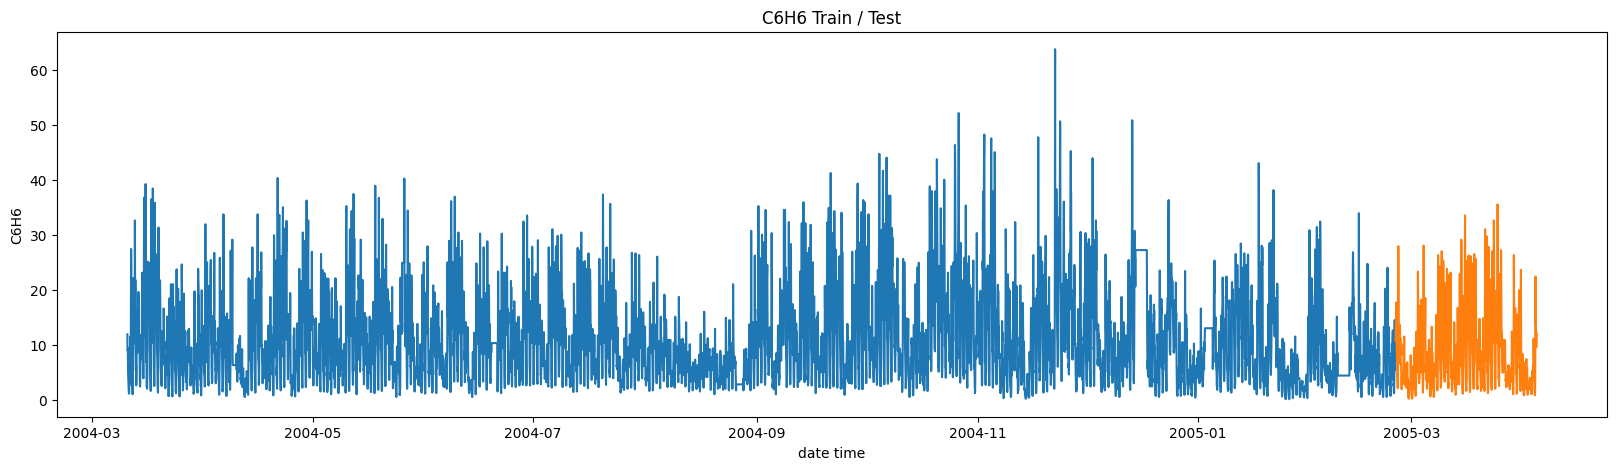

In [ ]:
plt.figure(figsize=(20, 5))

plt.plot(df_train.index, df_train['C6H6'], label='Train')
plt.plot(df_test.index, df_test['C6H6'], label='Test')

plt.title('C6H6 Train / Test')
plt.xlabel('date time')
plt.ylabel('C6H6')

plt.show()

In [ ]:
# Crear una instancia de AutoTS,
model1 = AutoTS(
    forecast_length=len(df_test),  # Longitud del período de pronóstico como solo quiero probar el modelo uso test
    frequency='H',  # Frecuencia de los datos H, D, M
    prediction_interval=0.95,  # Intervalo de confianza
    ensemble=None,  # Estrategia de ensemble (combinación de modelos)
    models_mode= 'default',  # Modo de modelos, puede ser 'simple', 'default', 'deep', empezar por default
    model_list='fast',  # Lista de modelos a probar, 'superfast' prueba modelos rápidos, fast, también default
    max_generations=15,  # Número máximo de generaciones para la optimización evolutiva
    num_validations=5,  # Número de validaciones cruzadas
    no_negatives=True,  # Evitar predicciones negativas, en la serie C6H6 no tendría sentido
    n_jobs='auto'  # Número de trabajos en paralelo, 'auto' utiliza todos los núcleos disponibles
)
#falló pr falta de memoria

Using 1 cpus for n_jobs.


In [ ]:
#Confifurara la lista de modelos de autoTS

from autots.models.model_list import model_lists
print(model_lists.keys())  # Lista de modelos disponibles

dict_keys(['all', 'default', 'fast', 'superfast', 'parallel', 'fast_parallel', 'fast_parallel_no_arima', 'scalable', 'probabilistic', 'multivariate', 'univariate', 'no_params', 'recombination_approved', 'no_shared', 'no_shared_fast', 'experimental', 'slow', 'gpu', 'regressor', 'best', 'motifs', 'all_result_path', 'regressions', 'all_pragmatic', 'update_fit'])


In [ ]:
#Para ver la lista de modelos específico

print(model_lists['superfast'])
print(model_lists['fast'])
print(model_lists['univariate'])


['ConstantNaive', 'LastValueNaive', 'AverageValueNaive', 'GLS', 'SeasonalNaive', 'SeasonalityMotif', 'SectionalMotif']
{'ConstantNaive': 1, 'LastValueNaive': 1.5, 'AverageValueNaive': 1, 'GLS': 1, 'SeasonalNaive': 1, 'GLM': 1, 'ETS': 1, 'VAR': 0.8, 'VECM': 0.8, 'WindowRegression': 0.5, 'DatepartRegression': 0.8, 'UnivariateMotif': 1, 'SectionalMotif': 1, 'NVAR': 0.3, 'MAR': 0.25, 'RRVAR': 0.4, 'KalmanStateSpace': 0.4, 'MetricMotif': 1, 'Cassandra': 0.6, 'SeasonalityMotif': 1.5, 'FFT': 0.8, 'BallTreeMultivariateMotif': 0.4}
['MLEnsemble', 'SeasonalNaive', 'KalmanStateSpace', 'MetricMotif', 'UnobservedComponents', 'ETS', 'ARCH', 'ARIMA', 'Theta', 'ConstantNaive', 'AverageValueNaive', 'UnivariateRegression', 'GLM', 'FBProphet', 'NeuralProphet', 'PreprocessingRegression', 'SeasonalityMotif', 'UnivariateMotif', 'GLS', 'LastValueNaive', 'FFT', 'DatepartRegression', 'ARDL']


In [ ]:
# Crear otra instancia de AutoTS más sencilla
model1 = AutoTS(
    forecast_length=len(df_test),
    frequency='H',
    prediction_interval=0.95,
    ensemble=None,
    models_mode= 'default',
    model_list='superfast',
    max_generations=10,
    num_validations=3,
    no_negatives=True,
    n_jobs='auto'
)

Using 1 cpus for n_jobs.


**Entrenar el modelo**

In [ ]:

modelAutoTS = model1.fit(df_train) #como hace validacion cruzada también se podría poner train y test
prediction = model1.predict(forecast_length=len(df_test)) # prediccion

Data frequency is: H, used frequency is: H
Model Number: 1 with model AverageValueNaive in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model GLS in generation 0 of 10
Model Number: 5 with model GLS in generation 0 of 10
Model Number: 6 with model LastValueNaive in generation 0 of 10
Model Number: 7 with model LastValueNaive in generation 0 of 10
Model Number: 8 with model LastValueNaive in generation 0 of 10
Model Number: 9 with model LastValueNaive in generation 0 of 10
Model Number: 10 with model SeasonalNaive in generation 0 of 10
Model Number: 11 with model SeasonalNaive in generation 0 of 10
Model Number: 12 with model SeasonalNaive in generation 0 of 10
Model Number: 13 with model ConstantNaive in generation 0 of 10
Model Number: 14 with model SeasonalNaive in generation 0 of 10
Model Number: 15 with model SectionalMotif in generation 0 of 10
Model Num

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Model Number: 46 with model ConstantNaive in generation 0 of 10
Model Number: 47 with model AverageValueNaive in generation 0 of 10
Model Number: 48 with model SeasonalityMotif in generation 0 of 10
Model Number: 49 with model GLS in generation 0 of 10
Model Number: 50 with model AverageValueNaive in generation 0 of 10
Model Number: 51 with model SectionalMotif in generation 0 of 10
Model Number: 52 with model SectionalMotif in generation 0 of 10
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 52 in generation 0: SectionalMotif
Model Number: 53 with model ConstantNaive in generation 0 of 10
Model Number: 54 with model SeasonalityMotif in generation 0 of 10
New Generation: 1 of 10
Model Number: 55 with model AverageValueNaive in generation 1 of 10
Template Eval Error: Exception("Transformer Detrend failed on fit from params rolling_mean_24 {'0': {'model': 'Poisson', 'phi': 0.999, 'window': 900, 'transform_dict': None}, '1': {'lag_1': 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 81 with model GLS in generation 1 of 10
Model Number: 82 with model LastValueNaive in generation 1 of 10
Model Number: 83 with model LastValueNaive in generation 1 of 10
Model Number: 84 with model ConstantNaive in generation 1 of 10
Model Number: 85 with model SeasonalNaive in generation 1 of 10
Model Number: 86 with model SeasonalityMotif in generation 1 of 10
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params rolling_mean_24 {'0': {'output_distribution': 'uniform', 'n_quantiles': 1000}, '1': {'window': 100}, '2': {'algorithm': 'parallel', 'fun': 'logcosh', 'max_iter': 100, 'whiten': 'unit-variance'}, '3': {'constant': 0, 'reintroduction_model': {'model': 'xgboost', 'model_params': {'booster': 'gblinear', 'max_depth': 6, 'eta': 0.3, 'min_child_weight': 1, 'subsample': 1, 'colsample_bylevel': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'quantile_alpha': 0.5, 'tree_method': 'hist'}, 'datepart_method': 'simple_2'}, 'fillna': 'mean'}}") in model 8

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.45599e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 157 with model GLS in generation 3 of 10
Model Number: 158 with model SectionalMotif in generation 3 of 10
Template Eval Error: Exception('Transformer QuantileTransformer failed on inverse from params rolling_mean_24 {\'0\': {\'output_distribution\': \'uniform\', \'n_quantiles\': 1000}, \'1\': {}} with ValueError("Input X contains infinity or a value too large for dtype(\'float64\').")') in model 158 in generation 3: SectionalMotif
Model Number: 159 with model SectionalMotif in generation 3 of 10
New Generation: 4 of 10


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 160 with model SectionalMotif in generation 4 of 10
Model Number: 161 with model GLS in generation 4 of 10
Model Number: 162 with model AverageValueNaive in generation 4 of 10
Model Number: 163 with model SeasonalNaive in generation 4 of 10


/usr/local/lib/python3.10/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 164 with model AverageValueNaive in generation 4 of 10
Model Number: 165 with model SectionalMotif in generation 4 of 10
Model Number: 166 with model AverageValueNaive in generation 4 of 10
Model Number: 167 with model GLS in generation 4 of 10
Model Number: 168 with model SeasonalNaive in generation 4 of 10
Model Number: 169 with model SeasonalNaive in generation 4 of 10
Model Number: 170 with model GLS in generation 4 of 10
Model Number: 171 with model AverageValueNaive in generation 4 of 10
Model Number: 172 with model SeasonalityMotif in generation 4 of 10
Model Number: 173 with model SectionalMotif in generation 4 of 10
Model Number: 174 with model GLS in generation 4 of 10
Model Number: 175 with model GLS in generation 4 of 10
Model Number: 176 with model SectionalMotif in generation 4 of 10
Model Number: 177 with model SeasonalNaive in generation 4 of 10
Model Number: 178 with model SeasonalNaive in generation 4 of 10
Model Number: 179 with model ConstantNaive in g

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 216 with model SeasonalNaive in generation 5 of 10
Model Number: 217 with model AverageValueNaive in generation 5 of 10
Model Number: 218 with model SectionalMotif in generation 5 of 10
Model Number: 219 with model SeasonalNaive in generation 5 of 10
Template Eval Error: Exception("Transformer BTCD failed on fit from params rolling_mean_24 {'0': {'method': 0.8}, '1': {'method': 'savgol_filter', 'method_args': {'window_length': 91, 'polyorder': 3, 'deriv': 0, 'mode': 'mirror'}}, '2': {'rows': 4, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None, 'threshold_method': 'max'}, '3': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 2}}") in model 219 in generation 5: SeasonalNaive
Model Number: 220 with model SectionalMotif in generation 5 of 10
Model Number: 221 with model SectionalMotif in generation 5 of 10
Model Number: 222 with model SeasonalityMotif in generation 5 of 10
New Generation: 6 of 10


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 238 with model GLS in generation 6 of 10
Model Number: 239 with model SeasonalNaive in generation 6 of 10
Model Number: 240 with model GLS in generation 6 of 10
Model Number: 241 with model GLS in generation 6 of 10
Model Number: 242 with model SectionalMotif in generation 6 of 10
Model Number: 243 with model SeasonalNaive in generation 6 of 10
Model Number: 244 with model SectionalMotif in generation 6 of 10
Model Number: 245 with model SeasonalNaive in generation 6 of 10
Model Number: 246 with model SeasonalNaive in generation 6 of 10
Model Number: 247 with model SectionalMotif in generation 6 of 10
Model Number: 248 with model AverageValueNaive in generation 6 of 10
Model Number: 249 with model AverageValueNaive in generation 6 of 10
Model Number: 250 with model AverageValueNaive in generation 6 of 10
New Generation: 7 of 10
Model Number: 251 with model GLS in generation 7 of 10


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 252 with model SectionalMotif in generation 7 of 10
Model Number: 253 with model SeasonalNaive in generation 7 of 10
Model Number: 254 with model AverageValueNaive in generation 7 of 10
Model Number: 255 with model AverageValueNaive in generation 7 of 10
Model Number: 256 with model SectionalMotif in generation 7 of 10
Model Number: 257 with model GLS in generation 7 of 10
Model Number: 258 with model AverageValueNaive in generation 7 of 10
Model Number: 259 with model SeasonalNaive in generation 7 of 10
Model Number: 260 with model SectionalMotif in generation 7 of 10
Model Number: 261 with model SeasonalNaive in generation 7 of 10


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 262 with model AverageValueNaive in generation 7 of 10
Model Number: 263 with model SeasonalNaive in generation 7 of 10
Model Number: 264 with model SeasonalNaive in generation 7 of 10
Model Number: 265 with model AverageValueNaive in generation 7 of 10
Model Number: 266 with model AverageValueNaive in generation 7 of 10
Model Number: 267 with model GLS in generation 7 of 10
Model Number: 268 with model SectionalMotif in generation 7 of 10


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 269 with model GLS in generation 7 of 10
Model Number: 270 with model AverageValueNaive in generation 7 of 10
Model Number: 271 with model AverageValueNaive in generation 7 of 10
Model Number: 272 with model SeasonalityMotif in generation 7 of 10
Model Number: 273 with model SeasonalNaive in generation 7 of 10
Model Number: 274 with model LastValueNaive in generation 7 of 10
Model Number: 275 with model SectionalMotif in generation 7 of 10
Model Number: 276 with model SeasonalNaive in generation 7 of 10
Model Number: 277 with model SectionalMotif in generation 7 of 10
Model Number: 278 with model AverageValueNaive in generation 7 of 10
New Generation: 8 of 10
Model Number: 279 with model SeasonalNaive in generation 8 of 10
Model Number: 280 with model SectionalMotif in generation 8 of 10
Model Number: 281 with model AverageValueNaive in generation 8 of 10
Model Number: 282 with model AverageValueNaive in generation 8 of 10
Model Number: 283 with model SectionalMotif in ge

/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1137: RuntimeWarning: overflow encountered in cast
  result.smoothed.states.cov[:, j, :, :] = Ps
/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1143: RuntimeWarning: overflow encountered in cast
  result.smoothed.observations.cov[:, j, :, :] = obs_cov
/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1354: RuntimeWarning: overflow encountered in matmul
  return np.matmul(A, np.swapaxes(B, -1, -2))
/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1354: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, np.swapaxes(B, -1, -2))
/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1341: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(A, B)
/usr/local/lib/python3.10/dist-packages/autots/tools/fast_kalman.py:1359: RuntimeWarning: overflow encountered in multiply
  return a * b.transpose((0, 2, 1))


SVD did not converge, attempting more robust approach...
Template Eval Error: Exception("Transformer KalmanSmoothing failed on fit from params rolling_mean {'0': {}, '1': {'lag': 2, 'fill': 'zero'}, '2': {'model_name': 'local linear hidden state with seasonal 7', 'state_transition': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]], 'process_noise': [[0.0016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], 'observation

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in divide
  avg = avg_as_array = np.multiply(a, wgt,


Model Number: 297 with model AverageValueNaive in generation 8 of 10
Model Number: 298 with model SectionalMotif in generation 8 of 10
Model Number: 299 with model AverageValueNaive in generation 8 of 10
Model Number: 300 with model AverageValueNaive in generation 8 of 10
Model Number: 301 with model SeasonalNaive in generation 8 of 10
Model Number: 302 with model SeasonalNaive in generation 8 of 10
Model Number: 303 with model SeasonalNaive in generation 8 of 10
Model Number: 304 with model GLS in generation 8 of 10
Model Number: 305 with model SeasonalityMotif in generation 8 of 10
Model Number: 306 with model SectionalMotif in generation 8 of 10
New Generation: 9 of 10
Model Number: 307 with model SeasonalNaive in generation 9 of 10
Model Number: 308 with model AverageValueNaive in generation 9 of 10
Model Number: 309 with model GLS in generation 9 of 10
Model Number: 310 with model AverageValueNaive in generation 9 of 10
Model Number: 311 with model SectionalMotif in generation 9 o

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 319 with model SeasonalityMotif in generation 9 of 10
Model Number: 320 with model GLS in generation 9 of 10
Model Number: 321 with model SeasonalNaive in generation 9 of 10
Model Number: 322 with model AverageValueNaive in generation 9 of 10
Model Number: 323 with model GLS in generation 9 of 10
Model Number: 324 with model GLS in generation 9 of 10
Model Number: 325 with model LastValueNaive in generation 9 of 10
Model Number: 326 with model SeasonalNaive in generation 9 of 10
Model Number: 327 with model AverageValueNaive in generation 9 of 10
Model Number: 328 with model AverageValueNaive in generation 9 of 10
Model Number: 329 with model SeasonalNaive in generation 9 of 10
Model Number: 330 with model AverageValueNaive in generation 9 of 10
Model Number: 331 with model SeasonalNaive in generation 9 of 10
Model Number: 332 with model SeasonalityMotif in generation 9 of 10
Model Number: 333 with model SectionalMotif in generation 9 of 10
Model Number: 334 with model Se

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 343 with model SeasonalNaive in generation 10 of 10


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Template Eval Error: Exception('Transformer RobustScaler failed on inverse from params ffill {\'0\': {}, \'1\': {}, \'2\': {}} with ValueError("Input contains infinity or a value too large for dtype(\'float64\').")') in model 343 in generation 10: SeasonalNaive
Model Number: 344 with model SeasonalNaive in generation 10 of 10


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Template Eval Error: ValueError("Model returned NaN due to a preprocessing transformer {'fillna': 'rolling_mean_24', 'transformations': {'0': 'PctChangeTransformer', '1': 'DifferencedTransformer'}, 'transformation_params': {'0': {}, '1': {'lag': 2, 'fill': 'zero'}}}. fail_on_forecast_nan=True") in model 344 in generation 10: SeasonalNaive
Model Number: 345 with model SeasonalNaive in generation 10 of 10
Model Number: 346 with model SectionalMotif in generation 10 of 10
Model Number: 347 with model SeasonalNaive in generation 10 of 10
Model Number: 348 with model AverageValueNaive in generation 10 of 10
Model Number: 349 with model SectionalMotif in generation 10 of 10
Model Number: 350 with model SeasonalNaive in generation 10 of 10
Model Number: 351 with model SeasonalNaive in generation 10 of 10
Model Number: 352 with model SeasonalityMotif in generation 10 of 10
Model Number: 353 with model SeasonalNaive in generation 10 of 10
Model Number: 354 with model AverageValueNaive in genera

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.68686e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


43 - SeasonalityMotif with avg smape 65.37: 
Model Number: 44 of 53 with model LastValueNaive for Validation 1
44 - LastValueNaive with avg smape 65.45: 
Model Number: 45 of 53 with model LastValueNaive for Validation 1
45 - LastValueNaive with avg smape 65.45: 
Model Number: 46 of 53 with model LastValueNaive for Validation 1
46 - LastValueNaive with avg smape 65.45: 
Model Number: 47 of 53 with model LastValueNaive for Validation 1
47 - LastValueNaive with avg smape 65.5: 
Model Number: 48 of 53 with model SeasonalityMotif for Validation 1
48 - SeasonalityMotif with avg smape 68.39: 
Model Number: 49 of 53 with model SeasonalityMotif for Validation 1
49 - SeasonalityMotif with avg smape 67.92: 
Model Number: 50 of 53 with model SeasonalityMotif for Validation 1
50 - SeasonalityMotif with avg smape 67.92: 
Model Number: 51 of 53 with model LastValueNaive for Validation 1
51 - LastValueNaive with avg smape 61.64: 
Model Number: 52 of 53 with model SeasonalityMotif for Validation 1
52 -

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.63306e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


43 - SeasonalityMotif with avg smape 65.72: 
Model Number: 44 of 53 with model LastValueNaive for Validation 2
44 - LastValueNaive with avg smape 71.04: 
Model Number: 45 of 53 with model LastValueNaive for Validation 2
45 - LastValueNaive with avg smape 71.04: 
Model Number: 46 of 53 with model LastValueNaive for Validation 2
46 - LastValueNaive with avg smape 71.04: 
Model Number: 47 of 53 with model LastValueNaive for Validation 2
47 - LastValueNaive with avg smape 71.01: 
Model Number: 48 of 53 with model SeasonalityMotif for Validation 2
48 - SeasonalityMotif with avg smape 70.83: 
Model Number: 49 of 53 with model SeasonalityMotif for Validation 2
49 - SeasonalityMotif with avg smape 66.05: 
Model Number: 50 of 53 with model SeasonalityMotif for Validation 2
50 - SeasonalityMotif with avg smape 66.05: 
Model Number: 51 of 53 with model LastValueNaive for Validation 2
51 - LastValueNaive with avg smape 65.8: 
Model Number: 52 of 53 with model SeasonalityMotif for Validation 2
52 -

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.5379e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


43 - SeasonalityMotif with avg smape 65.45: 
Model Number: 44 of 53 with model LastValueNaive for Validation 3
44 - LastValueNaive with avg smape 59.51: 
Model Number: 45 of 53 with model LastValueNaive for Validation 3
45 - LastValueNaive with avg smape 59.51: 
Model Number: 46 of 53 with model LastValueNaive for Validation 3
46 - LastValueNaive with avg smape 59.51: 
Model Number: 47 of 53 with model LastValueNaive for Validation 3
47 - LastValueNaive with avg smape 59.51: 
Model Number: 48 of 53 with model SeasonalityMotif for Validation 3
48 - SeasonalityMotif with avg smape 66.58: 
Model Number: 49 of 53 with model SeasonalityMotif for Validation 3
49 - SeasonalityMotif with avg smape 65.91: 
Model Number: 50 of 53 with model SeasonalityMotif for Validation 3
50 - SeasonalityMotif with avg smape 65.91: 
Model Number: 51 of 53 with model LastValueNaive for Validation 3
51 - LastValueNaive with avg smape 60.01: 
Model Number: 52 of 53 with model SeasonalityMotif for Validation 3
52 

In [ ]:
# Print de los detalles del mejor modelo.
print(model1)

Initiated AutoTS object with best model: 
SeasonalNaive
{'fillna': 'rolling_mean_24', 'transformations': {'0': 'ClipOutliers'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 2, 'fillna': None}}}
{'method': 'median', 'lag_1': 24, 'lag_2': 1}
Validation: 0, 1, 2, 3
SMAPE: 57.28115891736565, 55.78434561390349, 61.42148465824175, 50.82186319876454
MAE: 3.9576121794871795, 5.660630341880342, 6.8500267094017095, 6.215625000000001
SPL: 0.4469306631398476, 0.818206132220955, 0.4661444843927289, 0.6089801750661682


In [ ]:
# Metricas manuales teniendo train y test

mae = mean_absolute_error(df_test, prediction.forecast)
rmse = np.sqrt(mean_squared_error(df_test, prediction.forecast))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 4.291372863247863
RMSE: 5.49459081082648


In [ ]:
#Para exportar el modelo con todo los datos
model1.export_template(
    "model1.csv",
    models="best",
    max_per_model_class=1,
    include_results=True,
)

In [ ]:
# Acceder a los valores de predicción y bandas de confianza
forecast = prediction.forecast
lower_forecast = prediction.lower_forecast
upper_forecast = prediction.upper_forecast

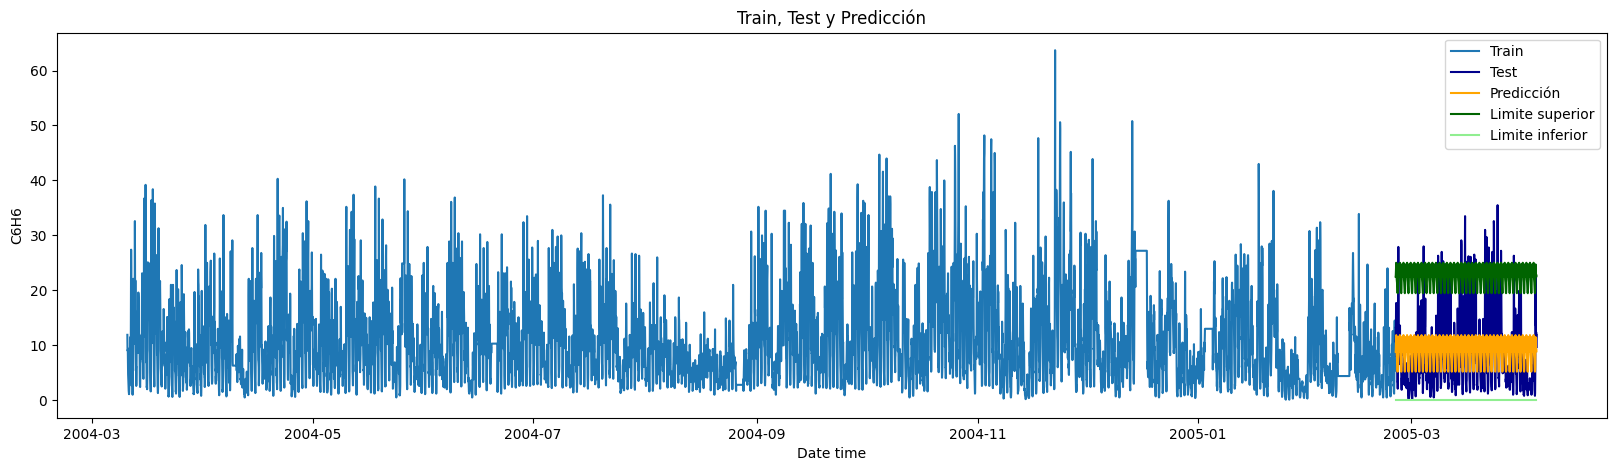

In [ ]:

fig,ax = plt.subplots(figsize=(20,5))
ax.plot(df_train,label='Train')
ax.plot(df_test, label='Test', color='darkblue')
ax.plot(prediction.forecast, label='Predicción', color='orange')
ax.plot(prediction.upper_forecast, label='Limite superior', color='darkgreen')
ax.plot(prediction.lower_forecast, label='Limite inferior', color='lightgreen')

ax.set_title('Train, Test y Predicción')
ax.set_xlabel('Date time')
ax.set_ylabel('C6H6')

ax.legend()

plt.show()

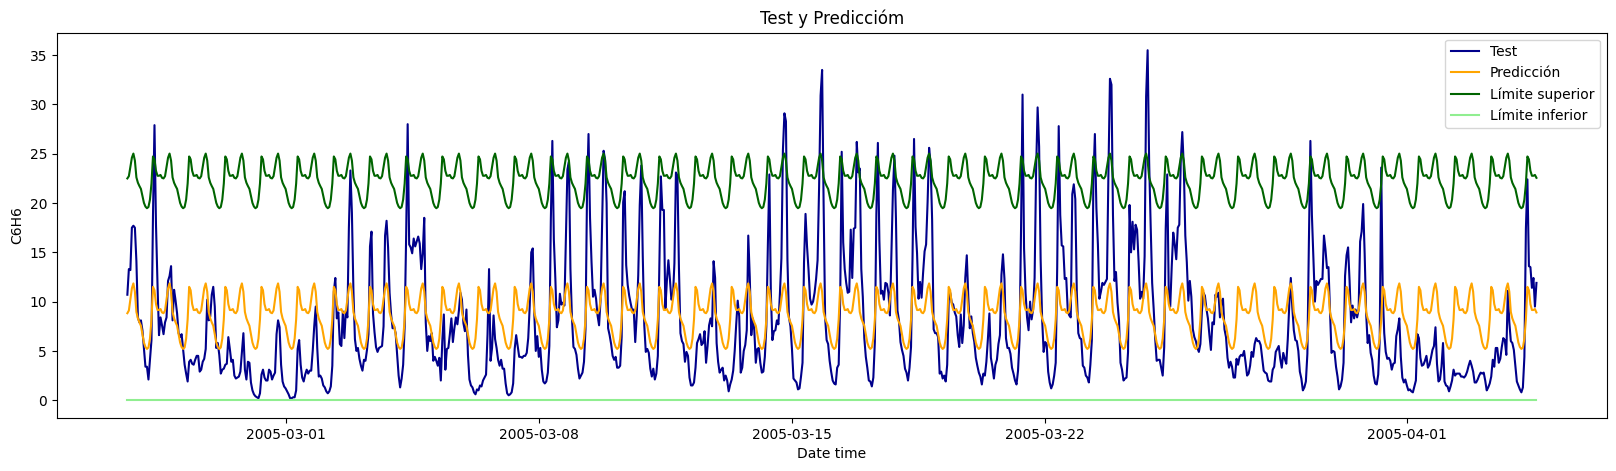

In [ ]:
#Sólo los datos de test

fig,ax = plt.subplots(figsize=(20,5))
ax.plot(df_test, label='Test', color='darkblue')
ax.plot(prediction.forecast, label='Predicción', color='orange')
ax.plot(prediction.upper_forecast, label='Límite superior', color='darkgreen')
ax.plot(prediction.lower_forecast, label='Límite inferior', color='lightgreen')

ax.set_title('Test y Prediccióm')
ax.set_xlabel('Date time')
ax.set_ylabel('C6H6')

ax.legend()

plt.show()



##**3. Auto Time Series - Modelado varible C6H6 con variables exogenas**

Levanto nuevamente los datos segun el n. 1

In [ ]:
print(df)


                     C6H6     T    RH
Datetime                             
2004-03-10 18:00:00  11.9  13.6  48.9
2004-03-10 19:00:00   9.4  13.3  47.7
2004-03-10 20:00:00   9.0  11.9  54.0
2004-03-10 21:00:00   9.2  11.0  60.0
2004-03-10 22:00:00   6.5  11.2  59.6
...                   ...   ...   ...
2005-04-04 10:00:00  13.5  21.9  29.3
2005-04-04 11:00:00  11.4  24.3  23.7
2005-04-04 12:00:00  12.4  26.9  18.3
2005-04-04 13:00:00   9.5  28.3  13.5
2005-04-04 14:00:00  11.9  28.5  13.1

[9357 rows x 3 columns]


In [ ]:
#Train y test
separador= len(df)*.9
separador = math.trunc(separador)
df_train = df[0:separador]
df_test = df[separador:]
df_train.head()

,C6H6,T,RH
Datetime,,,
2004-03-10 18:00:00,11.9,13.6,48.9
2004-03-10 19:00:00,9.4,13.3,47.7
2004-03-10 20:00:00,9.0,11.9,54.0
2004-03-10 21:00:00,9.2,11.0,60.0
2004-03-10 22:00:00,6.5,11.2,59.6


In [ ]:
model2 = AutoTS(
    forecast_length=len(df_test),
    frequency='H',
    prediction_interval=0.95,
    ensemble=None,
    models_mode='deep',
    model_list = 'superfast'  ,
    max_generations=10,
    num_validations=3,
    no_negatives=True,
    n_jobs='auto')

Using 1 cpus for n_jobs.


In [ ]:
#Modelo le agrego dos variables regresoras T y RH
modelAutoTS = model2.fit(df_train['C6H6'], future_regressor=df_train[['T','RH']])
prediction = model2.predict(forecast_length=len(df_test), future_regressor=df_test[['T', 'RH']])

Data frequency is: H, used frequency is: H
Model Number: 1 with model AverageValueNaive in generation 0 of 10
Model Number: 2 with model AverageValueNaive in generation 0 of 10
Model Number: 3 with model AverageValueNaive in generation 0 of 10
Model Number: 4 with model GLS in generation 0 of 10
Model Number: 5 with model GLS in generation 0 of 10
Model Number: 6 with model LastValueNaive in generation 0 of 10
Model Number: 7 with model LastValueNaive in generation 0 of 10
Model Number: 8 with model LastValueNaive in generation 0 of 10
Model Number: 9 with model LastValueNaive in generation 0 of 10
Model Number: 10 with model SeasonalNaive in generation 0 of 10
Model Number: 11 with model SeasonalNaive in generation 0 of 10
Model Number: 12 with model SeasonalNaive in generation 0 of 10
Model Number: 13 with model ConstantNaive in generation 0 of 10
Model Number: 14 with model SeasonalNaive in generation 0 of 10
Model Number: 15 with model SectionalMotif in generation 0 of 10
Model Num

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Model Number: 46 with model ConstantNaive in generation 0 of 10
Model Number: 47 with model AverageValueNaive in generation 0 of 10
Model Number: 48 with model SeasonalityMotif in generation 0 of 10
Model Number: 49 with model GLS in generation 0 of 10
Model Number: 50 with model AverageValueNaive in generation 0 of 10
Model Number: 51 with model SectionalMotif in generation 0 of 10
Model Number: 52 with model SectionalMotif in generation 0 of 10
Model Number: 53 with model ConstantNaive in generation 0 of 10
Model Number: 54 with model SeasonalityMotif in generation 0 of 10
New Generation: 1 of 10
Model Number: 55 with model SeasonalNaive in generation 1 of 10
Model Number: 56 with model SeasonalityMotif in generation 1 of 10
Model Number: 57 with model AverageValueNaive in generation 1 of 10
Model Number: 58 with model SeasonalNaive in generation 1 of 10
Model Number: 59 with model SeasonalityMotif in generation 1 of 10
Model Number: 60 with model SectionalMotif in generation 1 of 10

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 87 with model SeasonalityMotif in generation 1 of 10
Model Number: 88 with model SectionalMotif in generation 1 of 10
Model Number: 89 with model GLS in generation 1 of 10
New Generation: 2 of 10
Model Number: 90 with model SeasonalNaive in generation 2 of 10
Model Number: 91 with model LastValueNaive in generation 2 of 10
Model Number: 92 with model LastValueNaive in generation 2 of 10
Model Number: 93 with model SectionalMotif in generation 2 of 10
Model Number: 94 with model GLS in generation 2 of 10
Model Number: 95 with model SectionalMotif in generation 2 of 10
Model Number: 96 with model GLS in generation 2 of 10
Model Number: 97 with model AverageValueNaive in generation 2 of 10
Model Number: 98 with model SeasonalityMotif in generation 2 of 10
Model Number: 99 with model SectionalMotif in generation 2 of 10
Model Number: 100 with model ConstantNaive in generation 2 of 10
Model Number: 101 with model SectionalMotif in generation 2 of 10
Model Number: 102 with mode

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e+03, tolerance: 4.285e+01
  model = cd_fast.enet_coordinate_descent(


Model Number: 106 with model AverageValueNaive in generation 2 of 10
Model Number: 107 with model GLS in generation 2 of 10
Model Number: 108 with model SeasonalNaive in generation 2 of 10
Model Number: 109 with model SectionalMotif in generation 2 of 10
Model Number: 110 with model LastValueNaive in generation 2 of 10
Model Number: 111 with model ConstantNaive in generation 2 of 10


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Model Number: 112 with model AverageValueNaive in generation 2 of 10
Model Number: 113 with model SeasonalNaive in generation 2 of 10
Model Number: 114 with model AverageValueNaive in generation 2 of 10
Model Number: 115 with model LastValueNaive in generation 2 of 10
Model Number: 116 with model ConstantNaive in generation 2 of 10
Model Number: 117 with model SeasonalNaive in generation 2 of 10
Model Number: 118 with model SeasonalityMotif in generation 2 of 10
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill_mean_biased {'0': {'lag_1': 60, 'method': 'LastValue'}, '1': {'span': 12}, '2': {'lag_1': 7, 'method': 'Median'}, '3': {'det_order': 1, 'k_ar_diff': 0}, '4': {'lag': 1, 'fill': 'bfill'}}") in model 118 in generation 2: SeasonalityMotif
Model Number: 119 with model GLS in generation 2 of 10
Model Number: 120 with model LastValueNaive in generation 2 of 10
Model Number: 121 with model SeasonalNaive in generation 2 of 10
Model Number: 122 wit

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


Model Number: 247 with model AverageValueNaive in generation 6 of 10
Model Number: 248 with model SectionalMotif in generation 6 of 10
Model Number: 249 with model SectionalMotif in generation 6 of 10
Model Number: 250 with model GLS in generation 6 of 10
New Generation: 7 of 10
Model Number: 251 with model SeasonalNaive in generation 7 of 10
Model Number: 252 with model SectionalMotif in generation 7 of 10
Model Number: 253 with model SeasonalNaive in generation 7 of 10
Model Number: 254 with model SeasonalNaive in generation 7 of 10
Model Number: 255 with model GLS in generation 7 of 10
Model Number: 256 with model AverageValueNaive in generation 7 of 10
Model Number: 257 with model SeasonalNaive in generation 7 of 10
Model Number: 258 with model AverageValueNaive in generation 7 of 10
Model Number: 259 with model SeasonalityMotif in generation 7 of 10
Model Number: 260 with model GLS in generation 7 of 10
Model Number: 261 with model SeasonalityMotif in generation 7 of 10
Template E

/usr/local/lib/python3.10/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 272 with model SeasonalityMotif in generation 7 of 10
Model Number: 273 with model AverageValueNaive in generation 7 of 10
Model Number: 274 with model LastValueNaive in generation 7 of 10
Model Number: 275 with model SeasonalNaive in generation 7 of 10
Model Number: 276 with model SectionalMotif in generation 7 of 10
Model Number: 277 with model SectionalMotif in generation 7 of 10
Model Number: 278 with model SeasonalNaive in generation 7 of 10
New Generation: 8 of 10
Model Number: 279 with model SectionalMotif in generation 8 of 10
Model Number: 280 with model SeasonalNaive in generation 8 of 10
Model Number: 281 with model SectionalMotif in generation 8 of 10
Model Number: 282 with model AverageValueNaive in generation 8 of 10
Model Number: 283 with model AverageValueNaive in generation 8 of 10
Model Number: 284 with model SectionalMotif in generation 8 of 10
Model Number: 285 with model SeasonalityMotif in generation 8 of 10
Template Eval Error: Exception("Transforme

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.45599e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 318 with model SeasonalNaive in generation 9 of 10
Model Number: 319 with model AverageValueNaive in generation 9 of 10
Model Number: 320 with model AverageValueNaive in generation 9 of 10
Model Number: 321 with model AverageValueNaive in generation 9 of 10
Model Number: 322 with model GLS in generation 9 of 10
Model Number: 323 with model LastValueNaive in generation 9 of 10
Model Number: 324 with model AverageValueNaive in generation 9 of 10
Model Number: 325 with model SeasonalNaive in generation 9 of 10
Model Number: 326 with model SeasonalNaive in generation 9 of 10
Model Number: 327 with model AverageValueNaive in generation 9 of 10
Model Number: 328 with model SeasonalNaive in generation 9 of 10
Model Number: 329 with model SectionalMotif in generation 9 of 10
Model Number: 330 with model GLS in generation 9 of 10
Model Number: 331 with model GLS in generation 9 of 10
Model Number: 332 with model AverageValueNaive in generation 9 of 10
Model Number: 333 with model 

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 338 with model SeasonalNaive in generation 10 of 10
Model Number: 339 with model SeasonalityMotif in generation 10 of 10
Model Number: 340 with model SeasonalNaive in generation 10 of 10


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Model Number: 341 with model AverageValueNaive in generation 10 of 10
Model Number: 342 with model SectionalMotif in generation 10 of 10
Model Number: 343 with model SeasonalNaive in generation 10 of 10
Model Number: 344 with model AverageValueNaive in generation 10 of 10
Model Number: 345 with model AverageValueNaive in generation 10 of 10
Model Number: 346 with model AverageValueNaive in generation 10 of 10
Model Number: 347 with model SectionalMotif in generation 10 of 10
Model Number: 348 with model SeasonalityMotif in generation 10 of 10
Model Number: 349 with model SeasonalNaive in generation 10 of 10
Model Number: 350 with model SectionalMotif in generation 10 of 10
Model Number: 351 with model AverageValueNaive in generation 10 of 10
Model Number: 352 with model GLS in generation 10 of 10
Model Number: 353 with model SeasonalNaive in generation 10 of 10
Model Number: 354 with model SectionalMotif in generation 10 of 10
Model Number: 355 with model SectionalMotif in generation 1

In [ ]:
# Print de los detalles del mejor modelo.
print(model2)

Initiated AutoTS object with best model: 
GLS
{'fillna': 'ffill', 'transformations': {'0': 'SeasonalDifference', '1': 'ReplaceConstant', '2': 'PositiveShift', '3': 'CenterSplit', '4': 'BKBandpassFilter'}, 'transformation_params': {'0': {'lag_1': 168, 'method': 5}, '1': {'constant': 1, 'reintroduction_model': None, 'fillna': 'ffill'}, '2': {}, '3': {'fillna': 'ffill', 'center': 'median'}, '4': {'low': 6, 'high': 364, 'K': 1, 'lanczos_factor': False, 'return_diff': True, 'on_transform': False, 'on_inverse': True}}}
{}
Validation: 0, 1, 2, 3
SMAPE: 70.60573046390824, 56.76298983249672, 57.607290668397795, 42.44448525759631
MAE: 5.5756399090149955, 5.715247374936173, 5.646009237029707, 5.1493373040129296
SPL: 0.442303741781998, 0.7877310925549161, 0.40238127162773635, 0.5172545284715254


In [ ]:
#Métricas model2
mae = mean_absolute_error(df_test['C6H6'], prediction.forecast)
rmse = np.sqrt(mean_squared_error(df_test['C6H6'], prediction.forecast))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 5.28924139683736
RMSE: 6.461143364000876


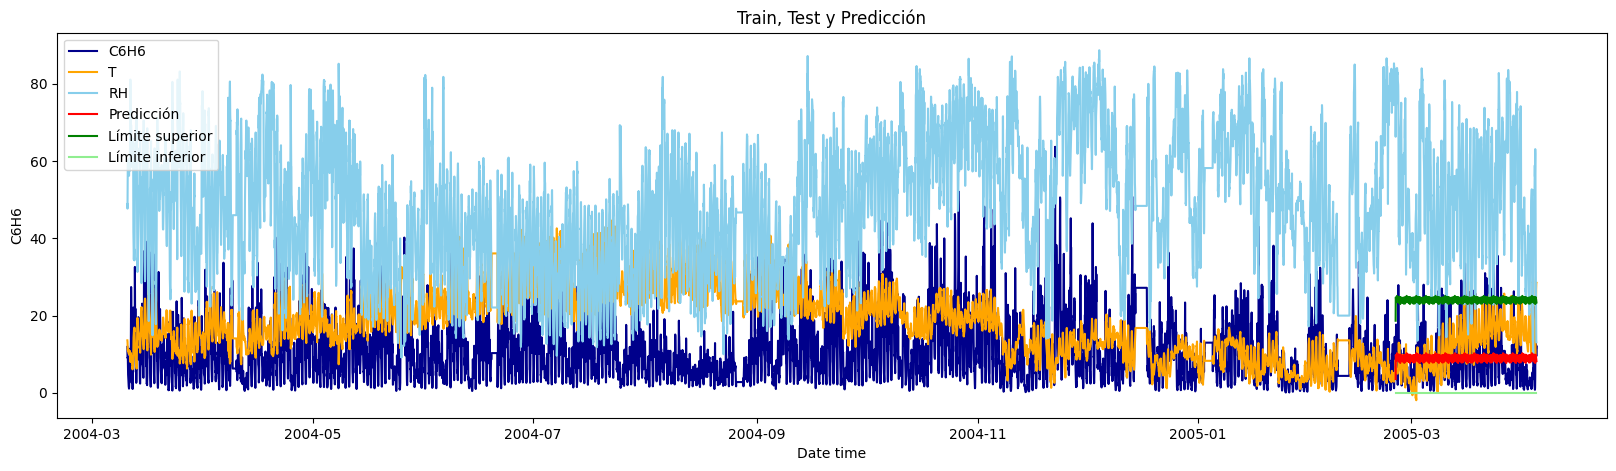

In [ ]:
fig,ax = plt.subplots(figsize=(20,5))

ax.plot(df ['C6H6'], label='C6H6', color= 'darkblue' )
ax.plot(df['T'], label='T', color= 'orange' )
ax.plot(df['RH'], label='RH', color= 'skyblue' )
ax.plot(prediction.forecast, label='Predicción', color='red')
ax.plot(prediction.upper_forecast, label='Límite superior', color='green')
ax.plot(prediction.lower_forecast, label='Límite inferior', color='lightgreen')

ax.set_title('Train, Test y Predicción')
ax.set_xlabel('Date time')
ax.set_ylabel('C6H6')

ax.legend()

plt.show()

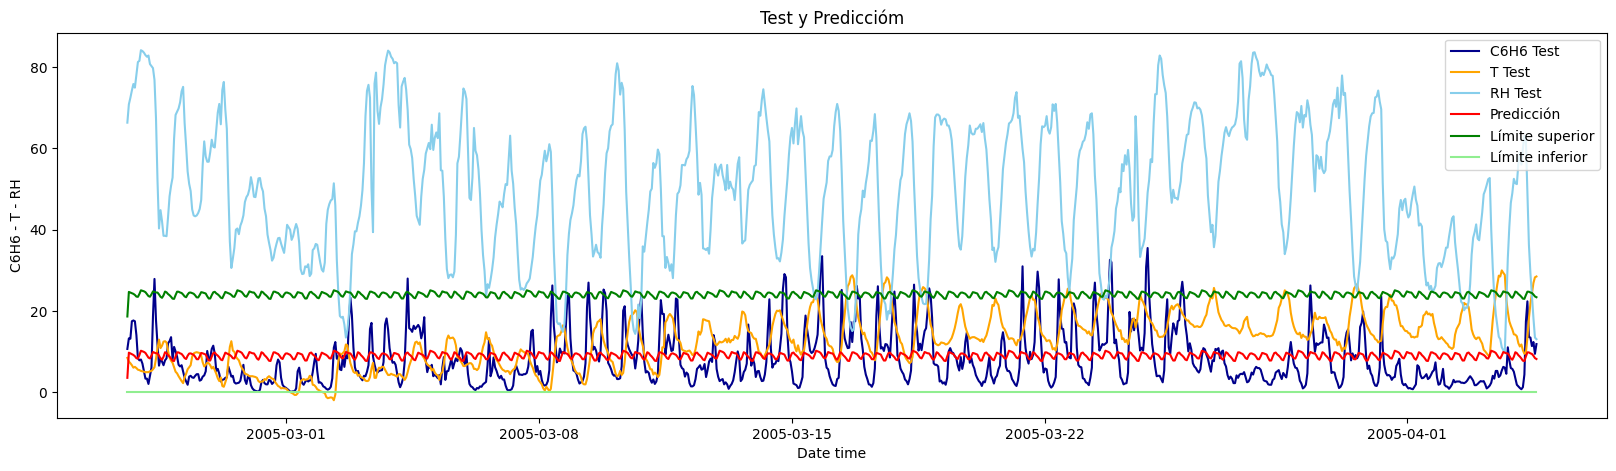

In [ ]:
#Sólo los datos de test

fig,ax = plt.subplots(figsize=(20,5))
ax.plot(df_test ['C6H6'], label='C6H6 Test', color= 'darkblue' )
ax.plot(df_test['T'], label='T Test', color= 'orange' )
ax.plot(df_test['RH'], label='RH Test', color= 'skyblue' )
ax.plot(prediction.forecast, label='Predicción', color='red')
ax.plot(prediction.upper_forecast, label='Límite superior', color='green')
ax.plot(prediction.lower_forecast, label='Límite inferior', color='lightgreen')

ax.set_title('Test y Prediccióm')
ax.set_xlabel('Date time')
ax.set_ylabel('C6H6 - T - RH')

ax.legend()

plt.show()